# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to apply a filter to the experiments so the RBFs are optimized only for possible drought conditions?
* How to avoid negative flows and negative supplied demand ratio in the operation policy?


In [47]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

In [48]:
from AMG_function import AMG_model

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model)

#define a +- multiplier of 15% for all the uncertainties
lowrange = 0.85
highrange = 1.15

#define a multiplier for all the water flows based on the average 2020 flow that represents drought and possible compensation by other sources
low_flow=0
high_flow=1.5

#Specify unceertainties
AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),
                           RealParameter('calderon_flow',low_flow,1*high_flow),
                           RealParameter('zapotillo_flow',low_flow,1*high_flow),
                           RealParameter('pozos_flow',low_flow,0.5*high_flow),
                           RealParameter('toluquilla_flow',low_flow,1*high_flow)]

AMG_model.levers = [RealParameter('mfc_flow_1',-1,1),
                    RealParameter('mfc_flow_2',-1,1),
                    RealParameter('mfc_flow_3',-1,1),
                    RealParameter('mfc_flow_4',-1,1)
]

AMG_model.outcomes = [ScalarOutcome("supplied_demand_1", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_2", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_3", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_4", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("supplied_demand_5", kind=ScalarOutcome.MAXIMIZE),
                      ScalarOutcome("min_supplied_demand", kind=ScalarOutcome.MAXIMIZE)
                      ]

#All uncertainties
'''AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),
                           RealParameter('private_intakes_1',445436*lowrange,445436*highrange), RealParameter('private_intakes_2',125446*lowrange,125446*highrange), RealParameter('private_intakes_3',147032*lowrange,147032*highrange), RealParameter('private_intakes_4',128862*lowrange,128862*highrange), RealParameter('private_intakes_5',199613*lowrange,199613*highrange),
                           RealParameter('public_consumption',129*lowrange,129*highrange),
                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),
                           RealParameter('node_division',0.35*lowrange,0.35*highrange),
                           RealParameter('loss_grid',0.3*lowrange,0.3*highrange), RealParameter('loss_potabilisation',0.05*lowrange,0.05*highrange),
                           RealParameter('rainfall',0,80*1.5), RealParameter('harvest_coeficient',0.75*lowrange,0.75*highrange), RealParameter('average_household_area',80*lowrange,80*highrange),
                           ]
        '''

"AMG_model.uncertainties = [RealParameter('chapala_flow',low_flow,6.3*high_flow),RealParameter('calderon_flow',low_flow,1*high_flow),RealParameter('zapotillo_flow',low_flow,1*high_flow),RealParameter('pozos_flow',low_flow,0.5*high_flow),RealParameter('toluquilla_flow',low_flow,1*high_flow),\n                           RealParameter('private_intakes_1',445436*lowrange,445436*highrange), RealParameter('private_intakes_2',125446*lowrange,125446*highrange), RealParameter('private_intakes_3',147032*lowrange,147032*highrange), RealParameter('private_intakes_4',128862*lowrange,128862*highrange), RealParameter('private_intakes_5',199613*lowrange,199613*highrange),\n                           RealParameter('public_consumption',129*lowrange,129*highrange),\n                           RealParameter('crowding_factor',3.55*lowrange,3.55*highrange),\n                           RealParameter('node_division',0.35*lowrange,0.35*highrange),\n                           RealParameter('loss_grid',0.3*lowra

In [49]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

n_scenarios = 1000
n_policies = 10
seed=23021995

experiments,results = perform_experiments(AMG_model, policies=n_policies, scenarios=n_scenarios)

[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
  0%|                                                | 0/10000 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|██████████████████████████████████| 10000/10000 [00:08<00:00, 1217.22it/s]
[MainProcess/INFO] experiments finished


In [50]:
import pandas as pd

experiments.head()

,calderon_flow,chapala_flow,pozos_flow,toluquilla_flow,zapotillo_flow,mfc_flow_1,mfc_flow_2,mfc_flow_3,mfc_flow_4,scenario,policy,model
0,0.330700,6.873680,0.584381,0.739395,1.164231,0.321212,-0.125761,-0.927065,0.15927,5042,5032,AMGmodel
1,0.793229,7.194201,0.334601,0.036517,0.488558,0.321212,-0.125761,-0.927065,0.15927,5043,5032,AMGmodel
2,1.345394,4.329645,0.088455,0.809543,1.350322,0.321212,-0.125761,-0.927065,0.15927,5044,5032,AMGmodel
3,0.438222,2.051559,0.689057,0.314236,0.024253,0.321212,-0.125761,-0.927065,0.15927,5045,5032,AMGmodel
4,1.039527,7.163554,0.219305,0.773704,0.168505,0.321212,-0.125761,-0.927065,0.15927,5046,5032,AMGmodel


In [51]:
import numpy as np

#getting experiments and results into a single dataframe for easier analysis and viz

results_df = pd.DataFrame(results, columns=["supplied_demand_1","supplied_demand_2","supplied_demand_3","supplied_demand_4","supplied_demand_5","min_supplied_demand"])
global_df = experiments.join(results_df)
global_df["total_extraction"] = global_df["chapala_flow"] + global_df["calderon_flow"] + global_df["zapotillo_flow"] + global_df["toluquilla_flow"] + global_df["pozos_flow"]
global_df = global_df.replace(np.nan, 0)

global_df.to_csv("global_df.csv")
global_df.head()

,calderon_flow,chapala_flow,pozos_flow,toluquilla_flow,zapotillo_flow,mfc_flow_1,mfc_flow_2,mfc_flow_3,mfc_flow_4,scenario,policy,model,supplied_demand_1,supplied_demand_2,supplied_demand_3,supplied_demand_4,supplied_demand_5,min_supplied_demand,total_extraction
0,0.330700,6.873680,0.584381,0.739395,1.164231,0.321212,-0.125761,-0.927065,0.15927,5042,5032,AMGmodel,1.204773,1.899970,1.554275,-0.384846,0.863466,1.554275,9.692388
1,0.793229,7.194201,0.334601,0.036517,0.488558,0.321212,-0.125761,-0.927065,0.15927,5043,5032,AMGmodel,1.258878,2.003418,1.386583,-1.015814,0.707820,1.386583,8.847108
2,1.345394,4.329645,0.088455,0.809543,1.350322,0.321212,-0.125761,-0.927065,0.15927,5044,5032,AMGmodel,0.775332,1.078888,2.499000,-0.321875,0.554437,2.499000,7.923359
3,0.438222,2.051559,0.689057,0.314236,0.024253,0.321212,-0.125761,-0.927065,0.15927,5045,5032,AMGmodel,0.390785,0.343640,0.741984,-0.766508,0.928692,0.741984,3.517328
4,1.039527,7.163554,0.219305,0.773704,0.168505,0.321212,-0.125761,-0.927065,0.15927,5046,5032,AMGmodel,1.253705,1.993526,1.328556,-0.354047,0.635974,1.328556,9.364595


C:\Users\ariel\AppData\Local\Temp\ipykernel_28156\812948482.py:12: UserWarning:


The markers list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.



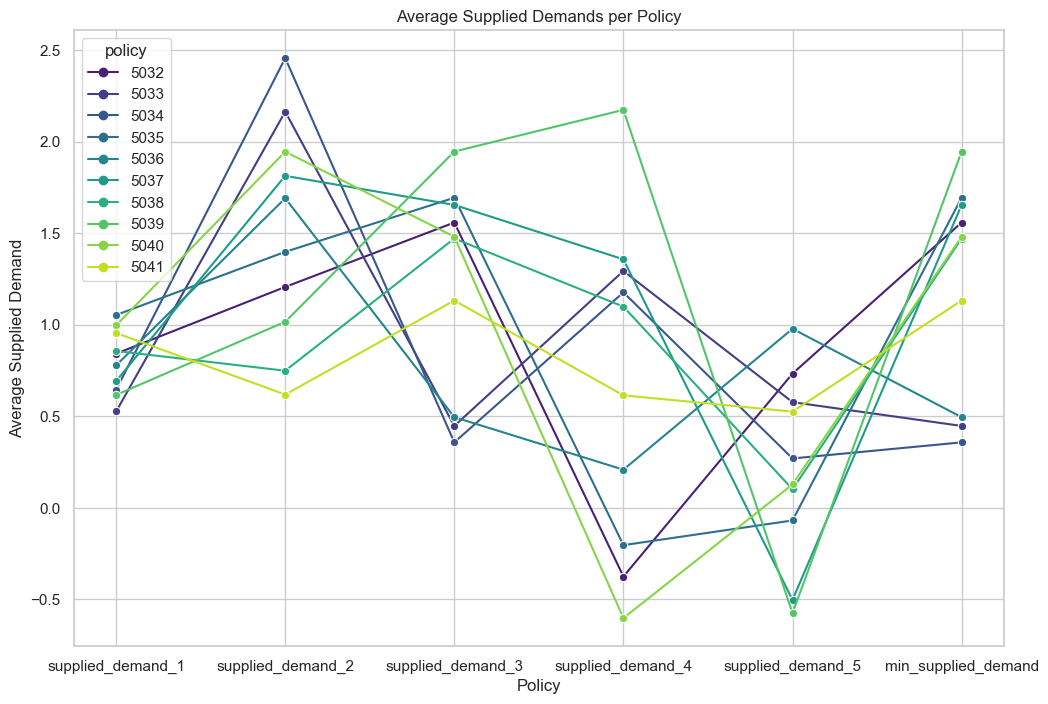

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the average of supplied demands per policy
average_demand_per_policy = global_df.groupby('policy')[['supplied_demand_1', 'supplied_demand_2', 'supplied_demand_3', 'supplied_demand_4', 'supplied_demand_5', 'min_supplied_demand']].mean()

# Create a parallel plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=average_demand_per_policy.T, dashes=False, markers="o", palette="viridis")

# Set plot labels and title
plt.xlabel('Policy')
plt.ylabel('Average Supplied Demand')
plt.title('Average Supplied Demands per Policy')

# Show the plot
plt.show()


In [53]:
import plotly.express as px
import pandas as pd


columns = ["supplied_demand_1", "supplied_demand_2", "supplied_demand_3", "supplied_demand_4","supplied_demand_5"]


data = pd.DataFrame({
    "supplied_demand_1": global_df[columns[0]],
    "supplied_demand_2": global_df[columns[1]],
    "supplied_demand_3": global_df[columns[2]],
    "supplied_demand_4": global_df[columns[3]],
    "supplied_demand_5": global_df[columns[4]]
})

# Create the parallel plot
fig = px.parallel_coordinates(data, dimensions=columns, color=global_df["total_extraction"])

# Show the plot
fig.show()


In [54]:
epsilons = [0.5]*5
print(epsilons)

[0.5, 0.5, 0.5, 0.5, 0.5]


In [55]:

epsilons = [0.9]*5



with MultiprocessingEvaluator(AMG_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=epsilons)

results.sort_values("mfc_flow_1")

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] terminating pool


EMAError: number of epsilon values does not match number of outcomes

In [ ]:

columns = ["supplied_demand_1", "supplied_demand_2", "supplied_demand_3", "supplied_demand_4","supplied_demand_5"]


data = pd.DataFrame({
    "supplied_demand_1": results[columns[0]],
    "supplied_demand_2": results[columns[1]],
    "supplied_demand_3": results[columns[2]],
    "supplied_demand_4": results[columns[3]],
    "supplied_demand_5": results[columns[4]]
})


fig = px.parallel_coordinates(data, dimensions=columns)


fig.show()

In [ ]:
results.sort_values("mfc_flow_1")

,mfc_flow_1,mfc_flow_2,mfc_flow_3,mfc_flow_4,supplied_demand_1,supplied_demand_2,supplied_demand_3,supplied_demand_4,supplied_demand_5
3,-0.945760,-0.790048,0.858059,-0.939107,9.025012e-08,3.164725,1.441784,2.183579,0.000004
0,-0.584564,-0.989229,0.520404,-0.853912,9.262913e-08,2.806583,1.915850,1.775419,0.000005
4,-0.294899,-0.897178,0.967236,-0.964591,8.953848e-08,2.519367,2.083026,2.313562,0.000003
1,0.380088,-0.972786,0.757612,-0.627537,9.895052e-08,1.850087,2.718011,1.785876,0.000004
2,0.590455,-0.967642,0.987827,-0.988624,8.886737e-08,1.641498,2.891624,2.356636,0.000002
